# GRU model

We start by importing the necessary libraries

In [78]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from core.util.plot_predictions import plot_predictions
from core.util.get_datasets import get_park_dataset
from core.util.trefor_dataset import TreforData
from core.util.loss_functions import zap_loss
from core.models import GRU
from core.models.model_training import train_model, test_model

## Setup
This section contains the setup for converting our data to something PyTorch can understand.
### Set hyperparameters for the model

In [79]:
batch_size = 512
EPOCHS = 10
lookback = 24
loss_function = zap_loss

### Get the park datasets and convert them to torch tensors

In [80]:
x_train, y_train, x_val, y_val, x_test, y_test = get_park_dataset(lookback, 24)
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()
x_val = torch.tensor(x_val).float()
y_val = torch.tensor(y_val).float()
x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()

### If the host has CUDA, it will use the GPU for computation

In [81]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Convert to specific Datasets for conversion to Dataloaders

In [82]:
train_dataset = TreforData(x_train, y_train, device)
val_dataset = TreforData(x_val, y_val, device)
test_dataset = TreforData(x_test, y_test, device)

### Convert to data to dataloaders
The DataLoader class helps us split the dataset into batches, and can also shuffle the data in between epochs if desired.

In [83]:
training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Creation of our simple GRU model
The implementation consist of three layers, defined in the `forward` method.
1. GRU
2. LeakyReLU
3. Linear

In [84]:
model = GRU(1, 10, 1, 0.2)
model.to(device)

GRU(
  (gru): GRU(1, 10, batch_first=True, dropout=0.2)
  (nl): LeakyReLU(negative_slope=0.01)
  (fc): Linear(in_features=240, out_features=24, bias=True)
)

### Training loop
Iterate the epochs, training and validating the model.

We save the model, in case it is better than any of the previous we have seen.

In [85]:
plot_train_loss, plot_val_loss, best_model = train_model(
    EPOCHS, model, zap_loss, training_loader, validation_loader
)

Iterating epochs:   0%|          | 0/10 [00:00<?, ?it/s]

### Use the best model to make predictions on the test set
This is very similar to the validation predictions above, only that this is run just once.

In [86]:
t_loss, predicted = test_model(best_model, zap_loss, testing_loader)
print(f"Avg loss: {t_loss:>8f} \n")

Avg loss: 0.008052 



## Plotting
Show some nice output :)
### Training- and validation loss

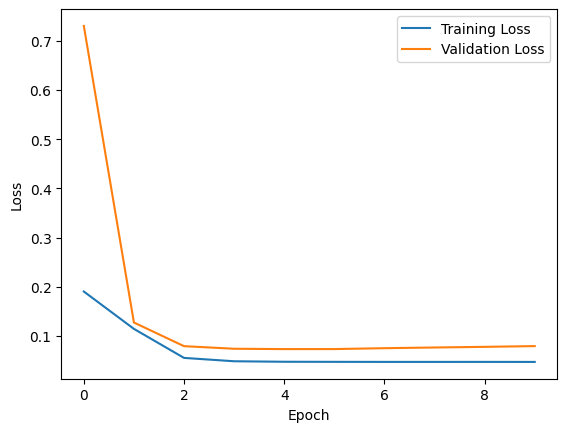

In [87]:
plt.clf()
plt.plot(plot_train_loss, label="Training Loss")
plt.plot(plot_val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Predictions- and actual consumption

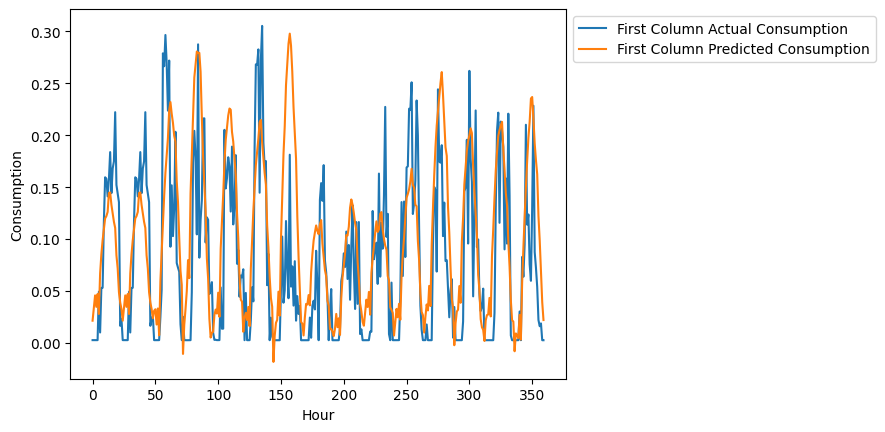

In [88]:
plot_predictions(500, 514, y_test, predicted)